In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import summarize_strategies, compute_turnover

In [2]:
# User settings
min_leverage = 0
max_leverage = 5
half_life = 20
f = 0.5
t_cost = 0.001
window_size = 2520

In [3]:
# Reading dataset
df = pd.read_excel('data/FFDaily.xlsx')
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df = df.rename(columns={
    "Mkt-RF": "xs_returns",
    "RF": "rf"
})

start_date = '1926-07-01'
end_date = '2024-12-31'
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

df = df[['Date', 'xs_returns', 'rf']]
df['xs_returns'] = df['xs_returns'] / 100
df['rf'] = df['rf'] / 100
df['total_returns'] = df['xs_returns'] + df['rf']

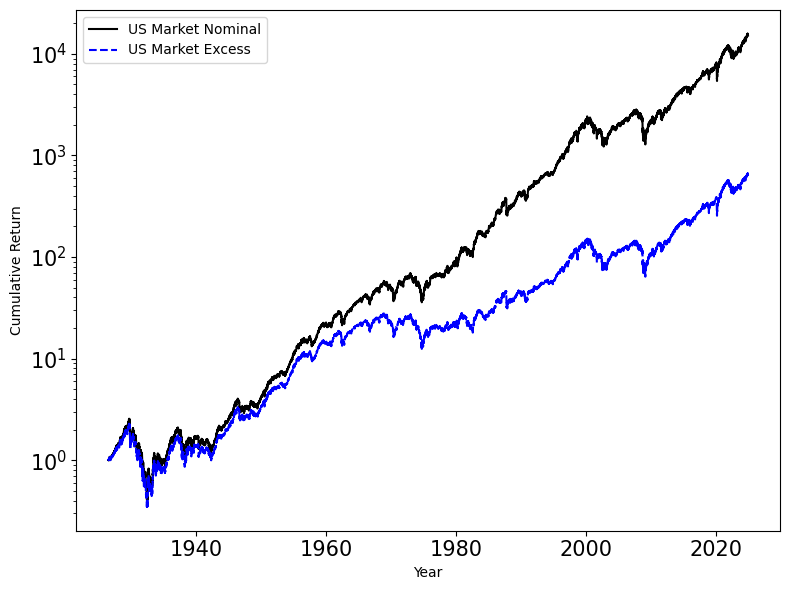

In [4]:
cum_total = np.cumprod(1 + df['total_returns'])
cum_excess = np.cumprod(1 + df['xs_returns'])

# Plot cumulative returns (Not in paper)
fig, ax = plt.subplots(figsize=(8, 6))

ax.semilogy(df['Date'], cum_total, 'k-', label='US Market Nominal')
ax.semilogy(df['Date'], cum_excess, 'b--', label='US Market Excess')

ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='upper left')
ax.tick_params(labelsize=15)

plt.tight_layout()
plt.show()

In [5]:
# Setting volatility as squared returns
df['squared_returns'] = df['xs_returns']**2

# Returns and volatility estimates (shifts to have return and estimates in sync)
df['vol'] = df['squared_returns'].ewm(halflife=half_life, adjust=False).mean()
df['mu_hat'] = df['xs_returns'].rolling(window=window_size, min_periods=window_size).mean().shift(1)
df['vol_pred'] = df['vol'].shift(1)

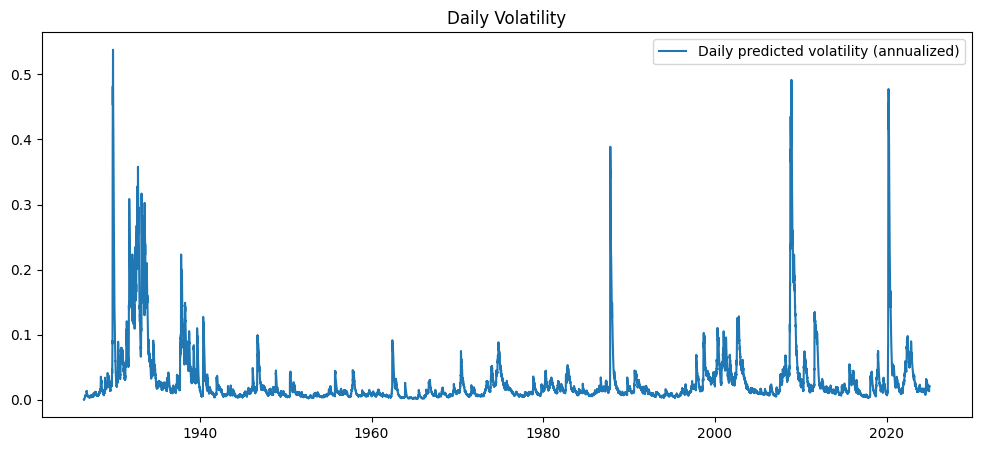

In [6]:
# Plot of volatility (Not in paper)
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['vol_pred'] * 252, label='Daily predicted volatility (annualized)')
plt.title('Daily Volatility')
plt.legend()
plt.show() 

In [7]:
df = df.dropna().reset_index(drop=True)

In [8]:
# Kelly weights
df['kelly_w'] = np.clip(((df['mu_hat'] / df['vol_pred']) * f), min_leverage, max_leverage)
df['kelly_xs_returns'] = df['xs_returns'] * df['kelly_w'] 
df['kelly_total_returns'] = df['kelly_xs_returns'] + df['rf']

In [9]:
# Volatility targeting weights
mean_var = np.mean(df['vol'])
df['vol_w'] = mean_var / df['vol_pred']
df['vol_xs_returns'] = df['xs_returns'] * df['vol_w']

# Rescale to have the same std. as the uncontidional strategy
benchmark_std = np.std(df['xs_returns'], ddof=1)
strategy_std = np.std(df['vol_xs_returns'], ddof=1)
scaling = benchmark_std / strategy_std
df['vol_w'] *= scaling
df['vol_w'] = np.clip(df['vol_w'], min_leverage, max_leverage)

df['vol_xs_returns'] = df['xs_returns'] * df['vol_w']
df['vol_total_returns'] = df['vol_xs_returns'] + df['rf']

In [10]:
# Placeholder for constant allocation
df['bh_w'] = np.ones_like(df['vol_w'])

In [11]:
BenchmarkNAV = np.cumprod(1 + df['total_returns'])
VolNAV = np.cumprod(1 + df['vol_total_returns'])
KellyNAV = np.cumprod(1 + df['kelly_total_returns'])

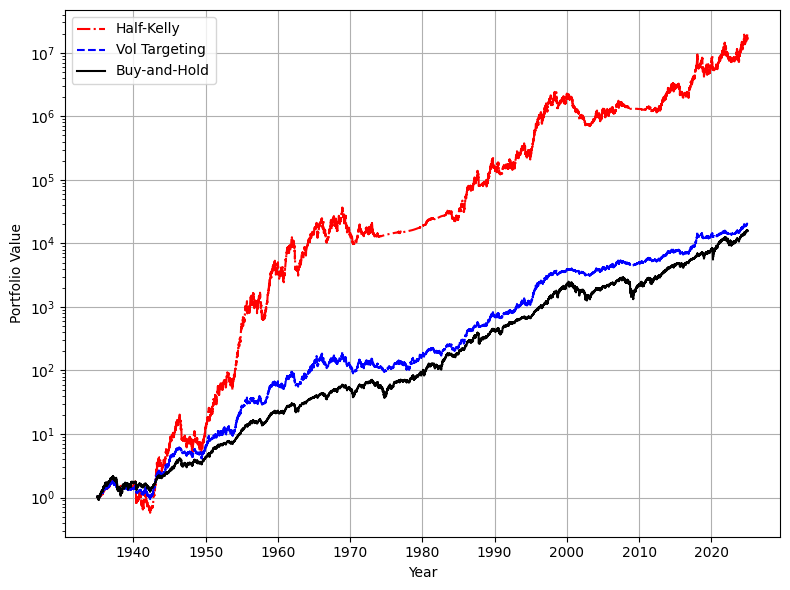

In [12]:
# Plotting wealth paths (Figure 7)
plt.figure(figsize=(8, 6))

plt.semilogy(df['Date'], KellyNAV, 'r-.', label='Half-Kelly')
plt.semilogy(df['Date'], VolNAV, 'b--', label='Vol Targeting')
plt.semilogy(df['Date'], BenchmarkNAV, 'k-', label='Buy-and-Hold')

plt.xlabel('Year')
plt.ylabel('Portfolio Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

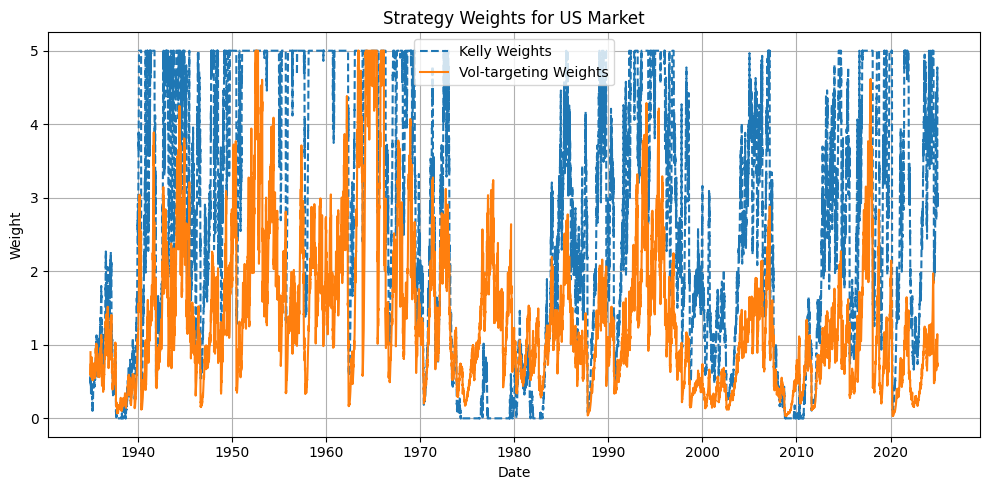

In [13]:
# Weights plot over time (Not in paper)
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['kelly_w'], label='Kelly Weights', linestyle='--')
plt.plot(df['Date'], df['vol_w'], label='Vol-targeting Weights', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.title('Strategy Weights for US Market')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
returns_dict = {
    'Buy-and-Hold': df['xs_returns'],
    'Volatility Targeting': df['vol_xs_returns'],
    'Half-Kelly': df['kelly_xs_returns']
}

rf_dict = {
    'Buy-and-Hold': df['rf'],
    'Volatility Targeting': df['rf'],
    'Half-Kelly': df['rf']
}

weights_dict = {
    "Buy-and-Hold": df['bh_w'],
    "Volatility Targeting": df['vol_w'],
    "Half-Kelly": df['kelly_w'],
}

# Table 8
results_df = summarize_strategies(returns_dict, rf_dict, weights_dict, rebalancing_freq=252)
summary_transposed = results_df.set_index('Strategy').T
display(summary_transposed.round(3))

Strategy,Buy-and-Hold,Volatility Targeting,Half-Kelly
Final Log Wealth,9.658,9.880,1.659600e+01
Average Allocation,1.000,1.339,2.714000e+00
Arithm. Total Return (%),11.604,11.821,2.374600e+01
Arithm. Excess Return (%),8.379,8.596,2.052100e+01
SR,0.544,0.564,6.060000e-01
Geom. Total Return (%),10.412,10.651,1.789300e+01
Geom. Excess Return (%),7.187,7.427,1.466900e+01
Geom. SR,0.466,0.488,4.330000e-01
Max Drawdown,-0.547,-0.539,-7.730000e-01
Terminal Wealth,15651.584,19545.281,1.612522e+07


## Transaction costs

In [15]:
# Compuitng turnover
turnover_vol = np.zeros(len(df))
turnover_kelly = np.zeros(len(df))

for i in range(len(df) - 1):
    asset_ret = df['total_returns'].iloc[i]     
    rf_ret = df['rf'].iloc[i]                       

    turnover_vol[i + 1], _ = compute_turnover(df['vol_w'].iloc[i], df['vol_w'].iloc[i + 1], asset_ret, rf_ret)
    turnover_kelly[i + 1], _ = compute_turnover(df['kelly_w'].iloc[i], df['kelly_w'].iloc[i + 1], asset_ret, rf_ret)

turnover_vol[0] = 1
turnover_kelly[0] = 1

In [16]:
xs_returns_vol_tc = df['vol_xs_returns'] - (t_cost * turnover_vol)
xs_returns_kelly_tc = df['kelly_xs_returns'] - (t_cost * turnover_kelly)

In [17]:
VolNAV_tc = np.cumprod(1 + xs_returns_vol_tc + df['rf'])
KellyNAV_tc = np.cumprod(1 + xs_returns_kelly_tc + df['rf'])

In [18]:
# Average turnover
print(turnover_vol.mean().round(3))
print(turnover_kelly.mean().round(3))

0.048
0.083


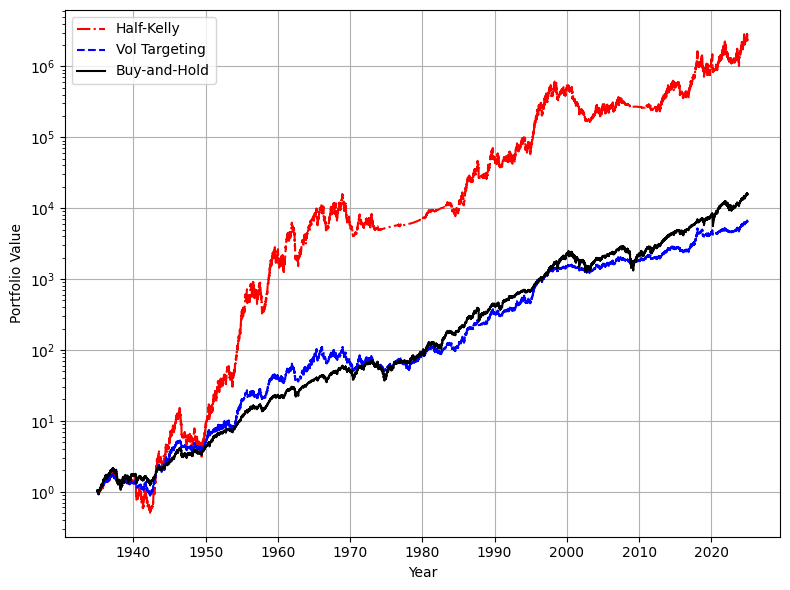

In [19]:
# Plotting wealth paths (Figure 7)
plt.figure(figsize=(8, 6))

plt.semilogy(df['Date'], KellyNAV_tc, 'r-.', label='Half-Kelly')
plt.semilogy(df['Date'], VolNAV_tc, 'b--', label='Vol Targeting')
plt.semilogy(df['Date'], BenchmarkNAV, 'k-', label='Buy-and-Hold')


plt.xlabel('Year')
plt.ylabel('Portfolio Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
returns_dict_TC = {
    'Buy-and-Hold': df['xs_returns'],
    'Volatility Targeting': xs_returns_vol_tc,
    'Half-Kelly': xs_returns_kelly_tc
}

rf_dict_TC = {
    'Buy-and-Hold': df['rf'],
    'Volatility Targeting': df['rf'],
    'Half-Kelly': df['rf']
}

# Table 8
results_df_TC = summarize_strategies(returns_dict_TC, rf_dict_TC, weights_dict, rebalancing_freq=252)
summary_transposed_TC = results_df_TC.set_index('Strategy').T
display(summary_transposed_TC.round(3))

Strategy,Buy-and-Hold,Volatility Targeting,Half-Kelly
Final Log Wealth,9.658,8.761,14.659
Average Allocation,1.000,1.339,2.714
Arithm. Total Return (%),11.604,10.614,21.658
Arithm. Excess Return (%),8.379,7.389,18.434
SR,0.544,0.485,0.544
Geom. Total Return (%),10.412,9.444,15.805
Geom. Excess Return (%),7.187,6.220,12.580
Geom. SR,0.466,0.408,0.371
Max Drawdown,-0.547,-0.550,-0.795
Terminal Wealth,15651.584,6379.944,2325157.319
